# Imports

In [101]:
import brian2 as br
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scmc.cmc import CMC

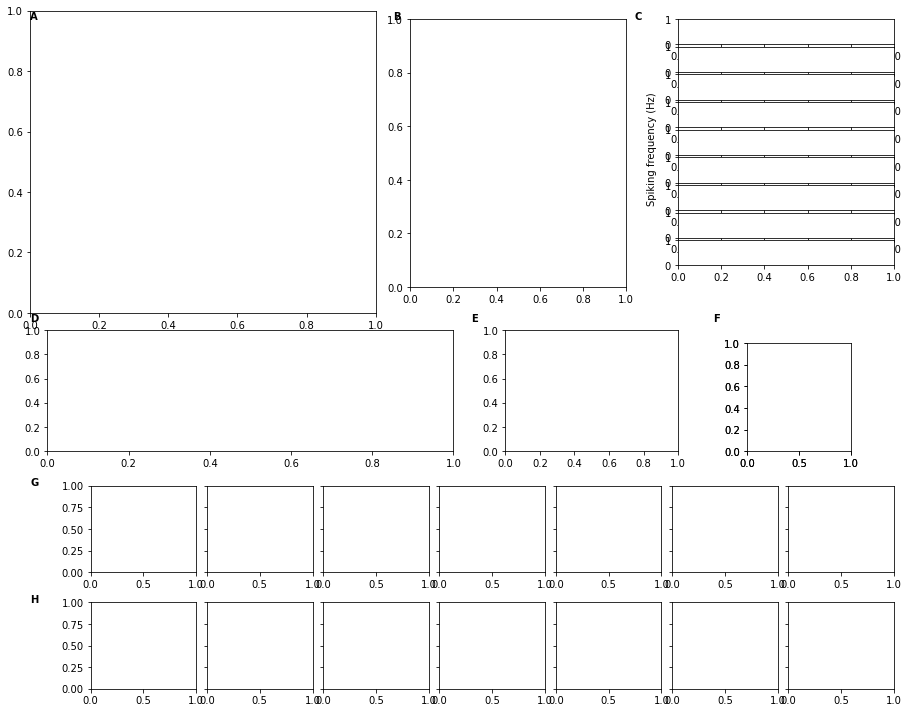

In [102]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12, 6), facecolor='white') #constrained_layout=False, 

gs_cmc_img = gridspec.GridSpec(1, 1, figure=fig, left=0.0, bottom=0.32, right=0.40, top=1.02)        
ax_cmc_img = fig.add_subplot(gs_cmc_img[0, 0])

gs_in_scat = gridspec.GridSpec(1, 1, figure=fig, left=0.44, bottom=0.38, right=0.69, top=1.0)
ax_in_scat = fig.add_subplot(gs_in_scat[0, 0])
              
gs_in_hist = gridspec.GridSpec(9, 1, figure=fig, left=0.75, bottom=0.43, right=1.0, top=1.0, hspace=0.1)  
axes_in_hist = [fig.add_subplot(gs_in_hist[i, 0]) for i in range(9)]

gs_erp_scat = gridspec.GridSpec(1, 1, figure=fig, left=0.02, bottom=0., right=0.49, top=0.28)
ax_erp_scat = fig.add_subplot(gs_erp_scat[0, 0])

gs_erp = gridspec.GridSpec(1, 1, figure=fig, left=0.55, bottom=0.0, right=0.75, top=0.28)  
ax_erp = fig.add_subplot(gs_erp[0, 0])

gs_p = gridspec.GridSpec(1, 1, figure=fig, left=0.83, bottom=0.0, right=0.95, top=0.25)  
ax_p = [fig.add_subplot(gs_p[0, 0]), fig.add_subplot(gs_p[0, 0], frame_on=False)]


gs_depol = gridspec.GridSpec(1, 7, figure=fig, left=0.07, bottom=-0.28, right=1.0, top=-0.08, wspace=0.1)  
ax_depol = gs_depol.subplots(sharex=True, sharey=True)

gs_p_erps = gridspec.GridSpec(1, 7, figure=fig, left=0.07, bottom=-0.55, right=1.0, top=-0.35, wspace=0.1)  
ax_p_erps = gs_p_erps.subplots(sharex=True, sharey=True)


fig.text(0, 1.0, "A", weight='bold')
fig.text(0.42, 1.0, "B", weight='bold')
fig.text(0.70, 1.0, "C", weight='bold')
fig.text(0, 0.3, "D", weight='bold')
fig.text(0.51, 0.3, "E", weight='bold')
fig.text(0.79, 0.3, "F", weight='bold')
fig.text(0, -0.08, "G", weight='bold')
fig.text(0, -0.35, "H", weight='bold')

fig.text(0.72, 0.7, "Spiking frequency (Hz)", verticalalignment="center",
         horizontalalignment="center", rotation=90);

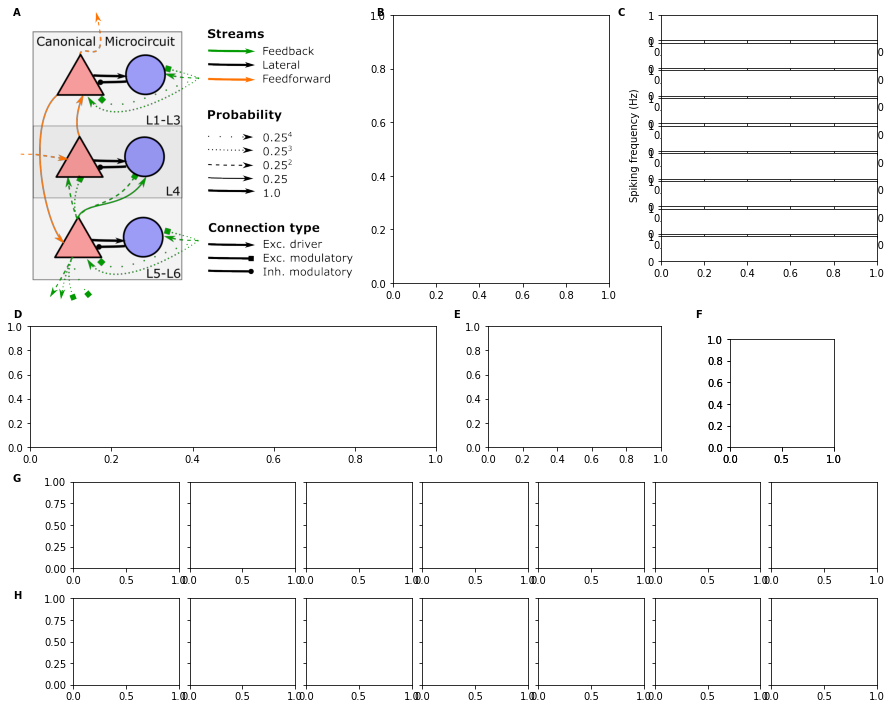

In [103]:
img = plt.imread("single_cmc.png")
ax_cmc_img.imshow(img)
ax_cmc_img.axison = False

fig

# Initializing a CMC

In [104]:
cmc = CMC()


  0%|          | 0/10 [00:00<?, ?it/s]

L13_inh L13_exc 1.0
L13_exc L13_inh 1.0
L4_inh L4_exc 1.0
L56_exc L4_exc 0.0625
L4_exc L4_inh 1.0
L56_exc L4_inh 0.25
L13_exc L56_exc 0.25
L4_exc L56_exc 0.25
L56_inh L56_exc 1.0
L56_exc L56_inh 1.0
inputs feedback 56 inh mod
inputs feedback 56 inh driver
inputs feedback 56 exc mod
inputs feedback 56 exc driver
inputs feedback 13 inh mod
inputs feedback 13 inh driver
inputs feedback 13 exc mod
inputs feedback 13 exc driver
inputs feedforward 4 exc driver


# Making a stimulation data frame

In [105]:
transient = 1.0
isi = 1.0
pulse_dur = 0.05
nb_iter = 60
sim_dur = transient + isi*nb_iter

starts = np.arange(transient, transient + nb_iter*isi, isi)
stops = np.arange(transient, transient + nb_iter*isi, isi) + pulse_dur

time = [0, 0, 0] + list(starts) + list(stops)
pop = ["feedback_input_L56", "feedback_input_L13", "feedforward_input_L4"] + ["feedforward_input_L4"]*len(starts) + ["feedforward_input_L4"]*len(stops)
status = [False, False, False] + [True]*len(starts) + [False]*len(stops)

stim_desc = pd.DataFrame({"time": time, "pop": pop, "status": status}).sort_values("time")

# Running the simulation

In [106]:
recompute = False
path_spikes_erp = Path("spikes_erp.csv")

if not path_spikes_erp.exists() or recompute:
    cmc.run_simulation(stim_desc, sim_dur)

    all_i = []
    all_t = []
    all_pop = []

    for pop_name, spike_mon in cmc.spike_monitors.items():
        i, t = spike_mon.it
        all_i.extend(list(i))
        all_t.extend(list(t/br.second))
        all_pop += [pop_name]*len(i)

    pd.DataFrame({"i": all_i, "t": all_t, "pop_name": all_pop}).to_csv(path_spikes_erp)

spikes_erp = pd.read_csv(path_spikes_erp, index_col=0)


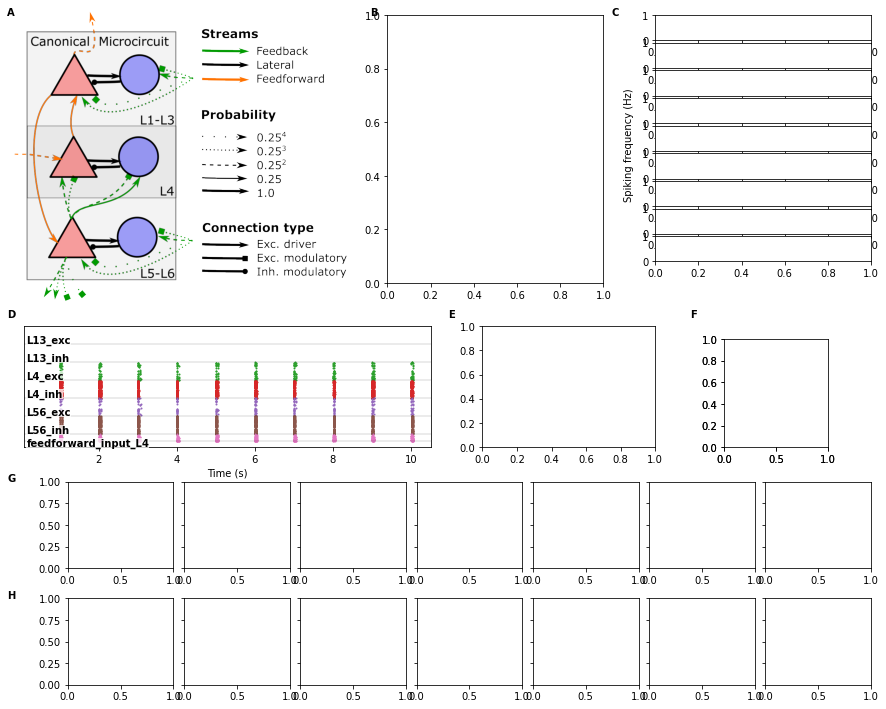

In [107]:
N = 0
nb_cell = 0
ax_erp_scat.axhline(y=0, alpha=0.1, color="k")
for pop_name, pop_df in spikes_erp.groupby("pop_name"):
    ax_erp_scat.scatter(pop_df.t.values, -pop_df.i.values-N, s=1, label=pop_name)
    N += len(cmc.pops[pop_name])

    nb_cell -= len(cmc.pops[pop_name])
    ax_erp_scat.axhline(y=nb_cell, alpha=0.1, color="k")

    if pop_name == "feedforward_input_L4":
        ax_erp_scat.text(0.15, nb_cell-12, pop_name, weight="bold",
                         bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=0.75))
    else:
        ax_erp_scat.text(0.15, nb_cell+4, pop_name, weight="bold",
                         bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=0.75))

ax_erp_scat.set_xlabel("Time (s)")
ax_erp_scat.set_xlim([0.1, 10.5])
ax_erp_scat.set_ylim([nb_cell*1.05, 0])
ax_erp_scat.set_yticks([])
ax_erp_scat.set_yticks([])

fig

In [108]:
# Get source signal
# Using spikes, but should ultimately be PSP

sim_dur = 61
dt = 0.001
exc_spikes = []
for pop_name, pop_df in spikes_erp.groupby("pop_name"):
    if "exc" in pop_name:  
        x = pop_df.t/dt
        x = x.round()*dt
        x = x.value_counts().sort_index()/len(cmc.pops[pop_name])*1000
        exc_spikes.append(x.reindex(np.arange(0, sim_dur, dt), fill_value=0).rolling(10, 1, True).mean())
cmc_output = pd.concat(exc_spikes, axis=1).sum(axis=1)

In [109]:
from deepjr.simulation import JRSimulator, EventRelatedExp
from deepjr.inference import JRInvModel

# Set up the simulator. This also create a head model for EEG simulation.
jr_sim = JRSimulator()

Reading forward solution from /Users/christian/Code/cmc/notebooks/fsaverage-fwd.fif.gz...


    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (8196 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [110]:
# Set the experiment.
jr_sim.experiment = EventRelatedExp(jr_sim.info, isi=1, nb_trial=60,
                                    stim_dur=0.05, transient_dur=0.8,
                                    epochs_tmin=-0.2)

raw, raw_snr = jr_sim.compute_raw_from_output(output=cmc_output, noise_fact=1, gain=1e-9)
evoked_cmc = jr_sim.experiment.get_epochs_from_raw(raw, tmin=-0.05, tmax=0.10).average()

Reading labels from parcellation...
   read 1 labels from /Applications/freesurfer/7.2.0/subjects/fsaverage/label/lh.aparc.annot
   read 0 labels from /Applications/freesurfer/7.2.0/subjects/fsaverage/label/rh.aparc.annot
Setting up raw simulation: 1 position, "cos2" interpolation
Event information not stored
    Interval 0.000–1.000 s
Setting up forward solutions
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval 0.000–1.000 s
    Interval

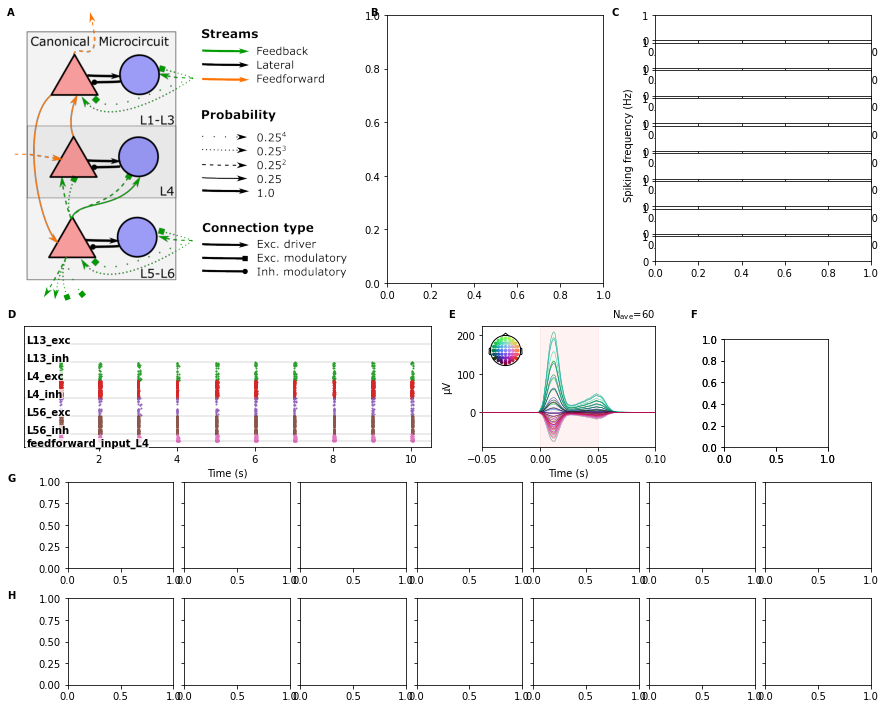

In [111]:
evoked_cmc.plot(axes=ax_erp)
ax_erp.fill_between(evoked_cmc.times, 0, 1, where= (evoked_cmc.times >= 0) & (evoked_cmc.times <= 0.05),
                color='red', alpha=0.05, transform=ax_erp.get_xaxis_transform())
ax_erp.set_title("")
fig

# Example with varying input

In [112]:
cmc = CMC()

  0%|          | 0/10 [00:00<?, ?it/s]

L13_inh L13_exc 1.0
L13_exc L13_inh 1.0
L4_inh L4_exc 1.0
L56_exc L4_exc 0.0625
L4_exc L4_inh 1.0
L56_exc L4_inh 0.25
L13_exc L56_exc 0.25
L4_exc L56_exc 0.25
L56_inh L56_exc 1.0
L56_exc L56_inh 1.0
inputs feedback 56 inh mod
inputs feedback 56 inh driver
inputs feedback 56 exc mod
inputs feedback 56 exc driver
inputs feedback 13 inh mod
inputs feedback 13 inh driver
inputs feedback 13 exc mod
inputs feedback 13 exc driver
inputs feedforward 4 exc driver


In [113]:
sim_dur = 6.0

stim_desc = [[0, False, "feedback_input_L56"],
             [0, False, "feedback_input_L13"],
             [0, False, "feedforward_input_L4"],
             [1, True,  "feedforward_input_L4"],
             [2, False, "feedforward_input_L4"],
             [2, True,  "feedback_input_L13"],
             [3, False, "feedback_input_L13"],
             [3, True,  "feedback_input_L56"],
             [4, True,  "feedback_input_L13"],
             [4, True,  "feedforward_input_L4"],
             [5, False, "feedback_input_L56"],
             [5, False, "feedback_input_L13"],
             [5, False, "feedforward_input_L4"],
             ]

stim_desc = pd.DataFrame(stim_desc, columns=["time", "status", "pop"]).sort_values("time")
stim_desc

,time,status,pop
0,0,False,feedback_input_L56
1,0,False,feedback_input_L13
2,0,False,feedforward_input_L4
3,1,True,feedforward_input_L4
4,2,False,feedforward_input_L4
5,2,True,feedback_input_L13
6,3,False,feedback_input_L13
7,3,True,feedback_input_L56
8,4,True,feedback_input_L13
9,4,True,feedforward_input_L4


In [114]:
recompute = False
path_spikes_input = Path("spikes_input.csv")

if not path_spikes_input.exists() or recompute:
    cmc.run_simulation(stim_desc, sim_dur)

    all_i = []
    all_t = []
    all_pop = []

    for pop_name, spike_mon in cmc.spike_monitors.items():
        i, t = spike_mon.it
        all_i.extend(list(i))
        all_t.extend(list(t/br.second))
        all_pop += [pop_name]*len(i)

    pd.DataFrame({"i": all_i, "t": all_t, "pop_name": all_pop}).to_csv(path_spikes_input)

spikes_input = pd.read_csv(path_spikes_input, index_col=0)

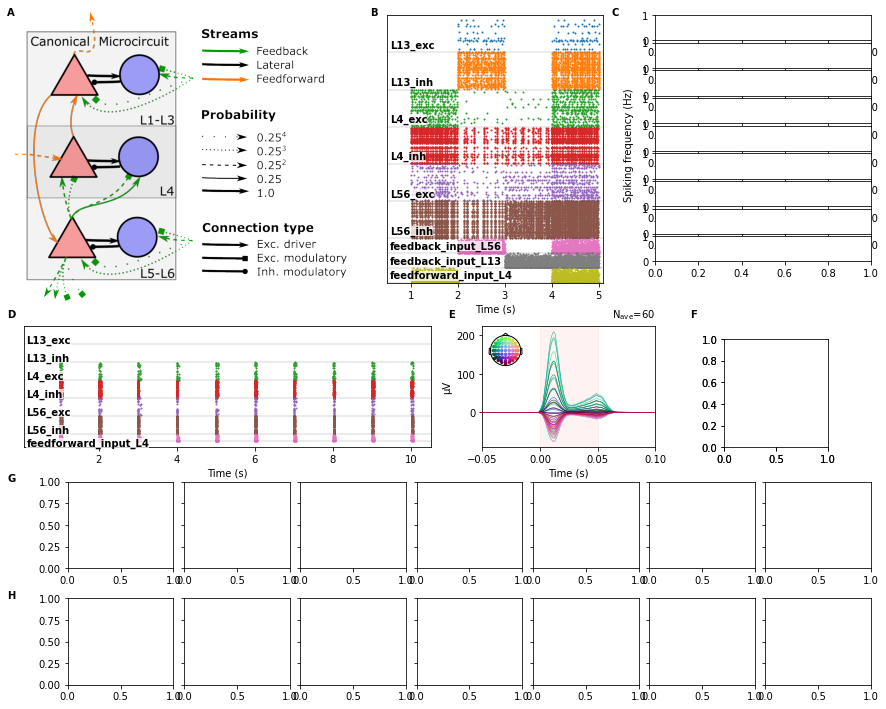

In [115]:
#fig, ax_in_scat = plt.subplots(1, 1)

N = 0
for pop_name, pop_df in spikes_input.groupby("pop_name"):
  ax_in_scat.scatter(pop_df.t.values, -pop_df.i.values-N, s=1, label=pop_name)
  N += len(cmc.pops[pop_name])

nb_cell = 0
ax_in_scat.axhline(y=0, alpha=0.1, color="k")
for pop_name in cmc.pops:
    nb_cell -= len(cmc.pops[pop_name])
    ax_in_scat.axhline(y=nb_cell, alpha=0.1, color="k")
    ax_in_scat.text(0.55, nb_cell+6, pop_name, weight="bold", color="black", 
                    bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=0.75))




#ax.legend(loc="upper left")
ax_in_scat.set_xlabel("Time (s)")
ax_in_scat.set_xlim([0.5, 5.1])
ax_in_scat.set_ylim([nb_cell, 0])
ax_in_scat.set_yticks([])
fig

In [116]:
tmax = 6 #cmc.network.t/br.second

for ax, (pop_name, pop_df) in zip(axes_in_hist, spikes_input.groupby("pop_name")):
  x = pop_df.t.round(3).value_counts().sort_index()/len(cmc.pops[pop_name])*1e3
  x.reindex(np.arange(0, tmax, 1e-3), fill_value=0).rolling(100, 1, True).mean().plot(ax=ax)
  ax.text(0.01, 0.65, pop_name, transform=ax.transAxes, weight="bold", 
          bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=0.75))
  ax.set_xlim(0.5, 5.1)

  # Computing the frequency using a 100ms rolling window. This operation is important
  # since computing instantaneous frequencies by counting spikes across cells
  # can lead to instantaneous frequencies that no single single cell can reach 
  # (i.e., unphysiological values).
  # The rolling window provide a computation similar to computing frequencies per cells and
  # then averaging with something like this:
  #  freq_series = [df.t.round(3).value_counts().reindex(np.arange(0, tmax, 0.001), fill_value=0).rolling(100, 1, True).sum()*10
  #               for i, df in spikes_input[spikes_input.pop_name == "L56_inh"].groupby("i")]
  #  pd.concat(freq_series, axis=1).mean(axis=1).plot()

ax.set_xlabel("Time (s)");

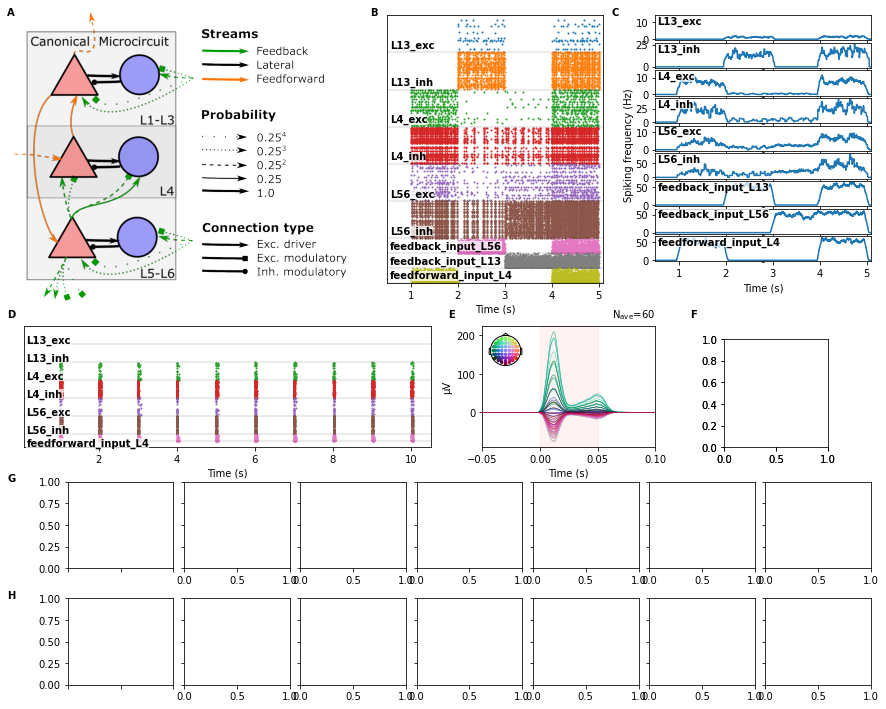

In [117]:
fig

# Example effect of varying parameters in the Izhikevich model

In [118]:
test_params = {"CH": dict(a=0.02/br.ms,  b=0.2/br.ms,  c=-50*br.mV, 
                          d=2*br.mV/br.ms, nb_neurons=1),
               "RS": dict(a=0.02/br.ms,  b=0.2/br.ms,  c=-65*br.mV, 
                          d=8*br.mV/br.ms, nb_neurons=1),
               "IB": dict(a=0.02/br.ms,  b=0.2/br.ms,  c=-55*br.mV, 
                          d=4*br.mV/br.ms, nb_neurons=1),
               "FS": dict(a=0.1/br.ms,   b=0.2/br.ms,  c=-65*br.mV, 
                          d=2*br.mV/br.ms, nb_neurons=1),
               "TC": dict(a=0.02/br.ms,  b=0.25/br.ms, c=-65*br.mV, 
                          d=0.05*br.mV/br.ms, nb_neurons=1),
               "RZ": dict(a=0.1/br.ms,   b=0.25/br.ms, c=-65*br.mV, 
                          d=2*br.mV/br.ms, nb_neurons=1),
               "LTS": dict(a=0.02/br.ms, b=0.25/br.ms, c=-65*br.mV, 
                           d=2*br.mV/br.ms, nb_neurons=1)}

In [119]:
params_df = pd.DataFrame(test_params)
params_df

,CH,RS,IB,FS,TC,RZ,LTS
a,20. Hz,20. Hz,20. Hz,100. Hz,20. Hz,100. Hz,20. Hz
b,200. Hz,200. Hz,200. Hz,200. Hz,250. Hz,250. Hz,250. Hz
c,-50. mV,-65. mV,-55. mV,-65. mV,-65. mV,-65. mV,-65. mV
d,2. V/s,8. V/s,4. V/s,2. V/s,0.05 V/s,2. V/s,2. V/s
nb_neurons,1,1,1,1,1,1,1


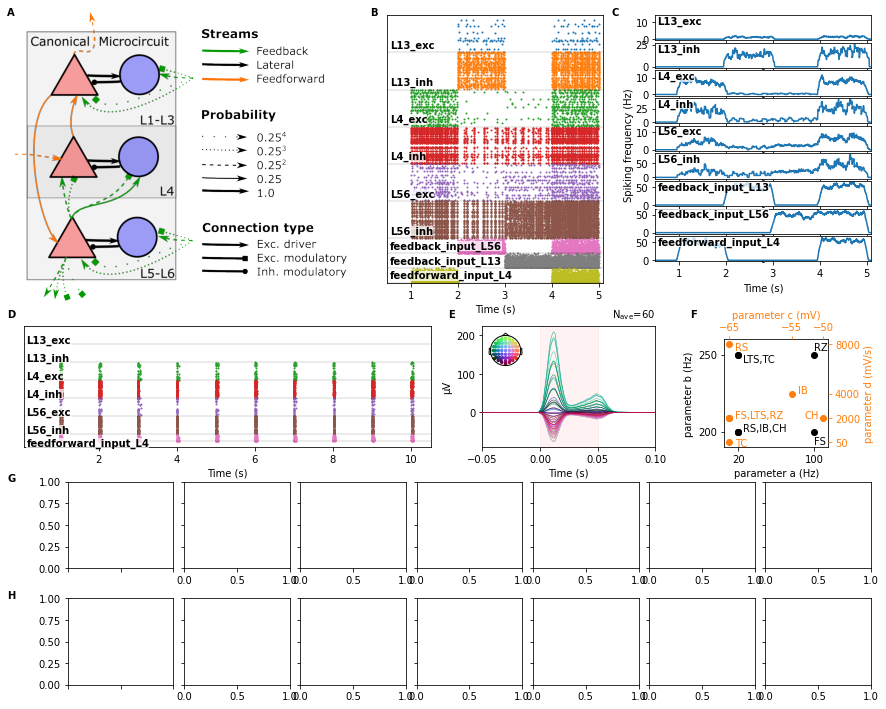

In [120]:

ax_p[0].scatter(params_df.loc["a"], params_df.loc["b"], c="k")
ax_p[0].set_xlabel('parameter a (Hz)', color="k") 
ax_p[0].set_ylabel('parameter b (Hz)', color="k")  
ax_p[0].set_xticks(params_df.loc["a"].astype(float).unique())
ax_p[0].set_yticks(params_df.loc["b"].astype(float).unique())
ax_p[0].set_xlim(5, 115)
ax_p[0].set_ylim(190, 260)

ax_p[0].text(25, 245, "LTS,TC")
ax_p[0].text(25, 200, "RS,IB,CH")
ax_p[0].text(100, 192, "FS")
ax_p[0].text(100, 253, "RZ")

param_c = (params_df.loc["c"]/br.mV).astype(float)
param_d = (params_df.loc["d"]/br.mV).astype(float)
ax_p[1].scatter(param_c, param_d, c="C1")
ax_p[1].xaxis.tick_top()
ax_p[1].yaxis.tick_right()
ax_p[1].set_xlabel('parameter c (mV)', color="C1") 
ax_p[1].set_ylabel('parameter d (mV/s)', color="C1")       
ax_p[1].xaxis.set_label_position('top') 
ax_p[1].yaxis.set_label_position('right') 
ax_p[1].tick_params(axis='x', colors="C1")
ax_p[1].tick_params(axis='y', colors="C1")
ax_p[1].set_xticks(param_c.unique())
ax_p[1].set_yticks(param_d.unique())

ax_p[1].text(-64, 2000, "FS,LTS,RZ", color="C1")
ax_p[1].text(-64, 7500, "RS", color="C1")
ax_p[1].text(-54, 4000, "IB", color="C1")
ax_p[1].text(-53, 2000, "CH", color="C1")
ax_p[1].text(-64, -250, "TC", color="C1")
fig

In [121]:
transient = 1.0
sim_dur = 2.0

time = [0, 0, 0] 
pop = ["feedback_input_L56", "feedback_input_L13", "feedforward_input_L4"] 
status = [False, False, False]

stim_desc = pd.DataFrame({"time": time, "pop": pop, "status": status}).sort_values("time")

In [122]:
def input_fct_t(nb_inputs):
    return br.TimedArray(np.ones(([0, 1], nb_inputs))*br.uA, 0.5*br.second)

def input_fct_p(n_inputs):
    return br.PoissonGroup(n_inputs, rates=np.linspace(10, 110, n_inputs)*br.Hz)


In [123]:
recompute = False

for pop_kind in test_params:
    fpath = Path(f"{pop_kind}_depol.csv")
    if recompute or not fpath.exists():
        pop_params = {label: CMC.get_default_pop_params(**test_params[pop_kind]) for label in CMC.pop_labels}

        cmc = CMC(pop_params=pop_params)
        cmc.run_simulation(stim_desc, 0.2)
        cmc.pops['L4_exc'].I = 15*br.mV/br.ms
        cmc.run_simulation(stim_desc, 0.7)

        df = pd.DataFrame(cmc.monitors['L4_exc'].v/br.mV, 
                        columns=cmc.monitors['L4_exc'].t/br.second)
        df.to_csv(fpath)


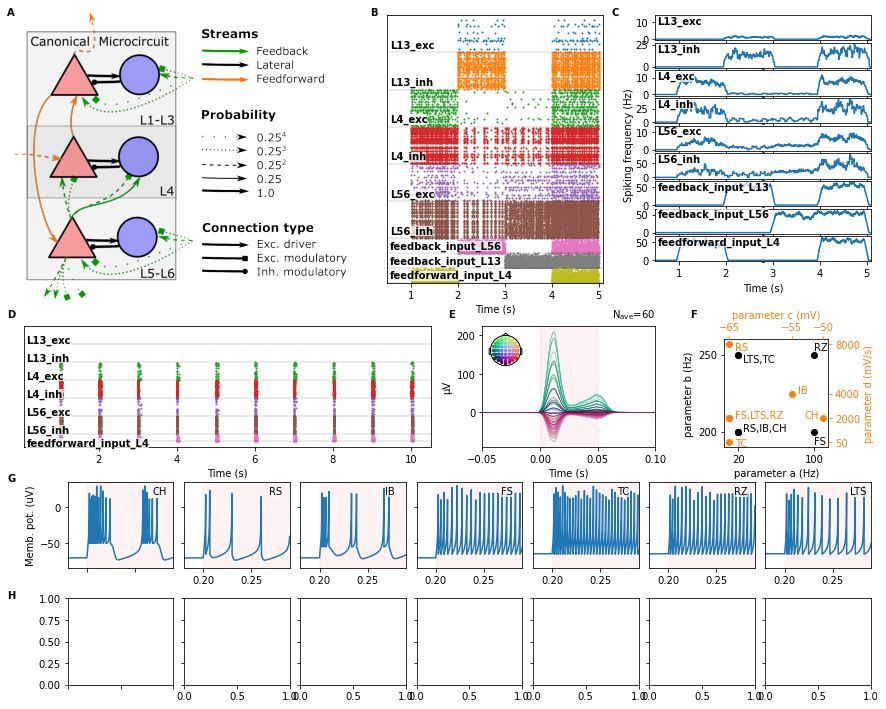

In [124]:
for pop_kind, ax in zip(test_params, ax_depol):
    df = pd.read_csv(f"{pop_kind}_depol.csv", index_col=0)
    v = df.iloc[0].values
    t = df.columns.values.astype(float)
    ax.plot(t, v)
    ax.set_xlim(0.18, 0.29)
    ax.text(0.8, 0.85, pop_kind, transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='none', pad=0, alpha=0.75))
    ax.fill_between(t, 0, 1, where= t >= 0.2,
                color='red', alpha=0.05, transform=ax.get_xaxis_transform())

ax_depol[0].set_ylabel("Memb. pot. (uV)")
    
fig

# Example of effect of Izhikevich parameters on ERPs

In [125]:
transient = 1.0
isi = 1.0
pulse_dur = 0.05
nb_iter = 60
sim_dur = transient + isi*nb_iter
dt = 0.001

# Set the experiment.
jr_sim.experiment = EventRelatedExp(jr_sim.info, isi=isi, nb_trial=nb_iter,
                                    stim_dur=pulse_dur, transient_dur=0.8,
                                    epochs_tmin=-0.2)


starts = np.arange(transient, transient + nb_iter*isi, isi)
stops = np.arange(transient, transient + nb_iter*isi, isi) + pulse_dur

time = [0, 0, 0] + list(starts) + list(stops)
pop = ["feedback_input_L56", "feedback_input_L13", "feedforward_input_L4"] + ["feedforward_input_L4"]*len(starts) + ["feedforward_input_L4"]*len(stops)
status = [False, False, False] + [True]*len(starts) + [False]*len(stops)

stim_desc = pd.DataFrame({"time": time, "pop": pop, "status": status}).sort_values("time")

In [126]:
recompute = False

np.random.seed(0)
for pop_kind in test_params:
    fpath = Path(f"{pop_kind}_erp.csv")

    if recompute or not fpath.exists():
        test_params_copy = test_params[pop_kind].copy()
        test_params_copy["nb_neurons"] = 50
        pop_params = {label: CMC.get_default_pop_params(**test_params[pop_kind]) for label in CMC.pop_labels}
        cmc = CMC(pop_params=pop_params)
        cmc.run_simulation(stim_desc, sim_dur)

        all_i = []
        all_t = []
        all_pop = []

        for pop_name, spike_mon in cmc.spike_monitors.items():
            i, t = spike_mon.it
            all_i.extend(list(i))
            all_t.extend(list(t/br.second))
            all_pop += [pop_name]*len(i)

        spikes_erp = pd.DataFrame({"i": all_i, "t": all_t, "pop_name": all_pop})

        exc_spikes = []
        for pop_name, pop_df in spikes_erp.groupby("pop_name"):
            if "exc" in pop_name:  
                x = pop_df.t/dt
                x = x.round()*dt
                x = x.value_counts().sort_index()/len(cmc.pops[pop_name])*1000
                exc_spikes.append(x.reindex(np.arange(0, sim_dur, dt), fill_value=0).rolling(10, 1, True).mean())
        pd.concat(exc_spikes, axis=1).sum(axis=1).to_csv(fpath)

Adding noise to 64/64 channels (64 channels in cov)
Not setting metadata
60 matching events found
Setting baseline interval to [-0.07, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Adding noise to 64/64 channels (64 channels in cov)
Not setting metadata
60 matching events found
Setting baseline interval to [-0.07, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Adding noise to 64/64 channels (64 channels in cov)
Not setting metadata
60 matching events found
Setting baseline interval to [-0.07, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Adding noise to 64/64 channels (64 channels in cov)
Not setting metadata
60 matching events found
Setting baseline interval to [-0.07, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subsp

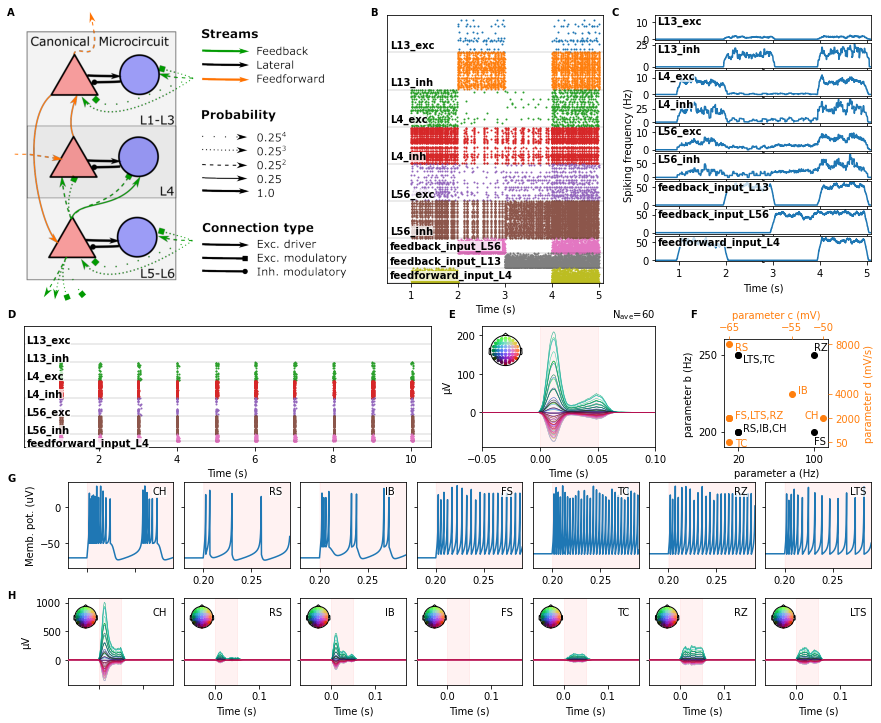

In [127]:
for pop_kind, ax in zip(test_params, ax_p_erps):
    cmc_output = pd.read_csv(f"{pop_kind}_erp.csv", index_col=0)["0"]

    raw, raw_snr = jr_sim.compute_raw_from_output(output=cmc_output, noise_fact=1, gain=1e-9, verbose=False)
    evoked_cmc = jr_sim.experiment.get_epochs_from_raw(raw, tmin=-0.07, tmax=0.17).average()

    evoked_cmc.plot(axes=ax, show=False, verbose=False)
    ax.set_title("")
    #if pop_kind != "CH":
    #    ax.set_ylabel("")

    ax.fill_between(evoked_cmc.times, 0, 1, where= (evoked_cmc.times >= 0) & (evoked_cmc.times <= 0.05),
                    color='red', alpha=0.05, transform=ax.get_xaxis_transform())


    ax.texts[1].set_visible(False)
    ax.text(0.8, 0.8, pop_kind, transform=ax.transAxes)
    #ax.tick_params(axis="y",direction="in", pad=-22)
fig

In [128]:
fig.savefig("prelim_cmc.png", dpi=300, bbox_inches='tight')